<a href="https://colab.research.google.com/github/abdelazizchaqdid/abdelazizchaqdid.github.io/blob/main/ExGAN_clean_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Prepeare the environment

In [ ]:
# Needed to plot rainfall maps. Restart runtime after installation (Option in the cell output)
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip
!pip install basemap
!pip install netCDF4
!pip install torch==2.0.1 torchvision==0.15.2 torchaudio==2.0.2
!pip install tensorboardX

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgeos-dev is already the newest version (3.11.1-1~jammy0).
libgeos-dev set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
     | 129.8 MB 26.0 MB/s 0:00:13
ERROR: https://github.com/matplotlib/basemap/archive/master.zip does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


In [ ]:
from netCDF4 import Dataset as NetCDFFile
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from urllib.request import urlretrieve
import os
from torch.utils.data import Dataset, DataLoader
from skimage.transform import resize
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import LongTensor, FloatTensor
import torch.optim as optim
from scipy.stats import skewnorm, genpareto
from torchvision.utils import save_image
import sys
import torch.utils.data
from tqdm import tqdm
from mpl_toolkits.basemap import Basemap, cm
import tensorflow as tf
from tensorboardX import SummaryWriter
from torchvision import transforms
from scipy import linalg
import warnings
from datetime import datetime


## Load the data

### Train data

In [ ]:
class NWSDataset(Dataset):
    """
    NWS Dataset
    """

    def __init__(
        self, path='data', prefix="ERA5_RR_"
    ):
        self.path = path
        self.files = [
                        f
                        for f in os.listdir(path)
                        if f.startswith(prefix) and os.path.isfile(os.path.join(path, f))
                    ]
        self.maxclip = 100

    def __len__(self):
        return len(self.files)

    def __getitem__(self, item):
        nc = NetCDFFile(
            os.path.join(self.path,self.files[item])
        )
        prcpvar = nc.variables["tp"]
        data = prcpvar[::-1, :]
        data = FloatTensor(data)
        data = data.view((-1, 64, 64))
        data = torch.clamp(data, max=self.maxclip)
        data = data / self.maxclip
        data = (data * 2) - 1  # Between -1 and 1
        return data

dataloader = DataLoader(NWSDataset(), batch_size=256, shuffle=True)
data = []
for i in dataloader:
    data.append(i)
data = torch.cat(data, 0)
sums = (data.sum(dim=(1,2,3))).detach().cpu().numpy().argsort()[::-1].copy()
torch.save(data.data[sums], 'data/real.pt')
data.shape

torch.Size([15, 1, 64, 64])

### Test data

In [ ]:

class NWSDataset(Dataset):
    """
    NWS Dataset
    """

    def __init__(
        self, path='test', prefix="ERA5_RR_"
    ):
        self.path = path
        self.files = [
                        f
                        for f in os.listdir(path)
                        if f.startswith(prefix) and os.path.isfile(os.path.join(path, f))
                    ]
        self.maxclip = 200

    def __len__(self):
        return len(self.files)

    def __getitem__(self, item):
        nc = NetCDFFile(
            os.path.join(self.path,self.files[item])
        )
        prcpvar = nc.variables["tp"]
        data = prcpvar[::-1, :]
        data = FloatTensor(data)
        data = data.view((-1, 64, 64))
        data = torch.clamp(data, max=self.maxclip)
        data = data / self.maxclip
        data = (data * 2) - 1  # Between -1 and 1
        return data

dataloader = DataLoader(NWSDataset(), batch_size=256, shuffle=True)
data = []
for i in dataloader:
    data.append(i)
data = torch.cat(data, 0)
sums = (data[:, :, 44:46,42:43].sum(dim=(1,2,3))).detach().cpu().numpy().argsort()[::-1].copy()
torch.save(data.data[sums], 'test/test.pt')
data.shape

FileNotFoundError: [Errno 2] No such file or directory: 'test'

## Define a plotting function

In [ ]:
latcorners = np.array([24, 24, 40 , 40 ])
loncorners = np.array([-16,-16, 0,  0])

lon_0 = -16 + (0 - (-16))/2
lat_0 = 24 + (40 - 24)/2

def plot_precip(data):
	'''
	data is a 813*1051 matrix containing unnormalized precipitation values
	'''
	if len(data.shape) == 3:
		data = data[0]
	data = (data+1)*50
	fig = plt.figure(figsize=(8,8))
	ax = fig.add_axes([0.1,0.1,0.8,0.8])
	m = Basemap(projection='cyl',lon_0=lon_0,lat_0=90.,lat_ts=lat_0,\
	            llcrnrlat=latcorners[0],urcrnrlat=latcorners[2],\
	            llcrnrlon=loncorners[0],urcrnrlon=loncorners[2],\
	            rsphere=6371200.,resolution='i', area_thresh=1000)
	m.drawcoastlines()
	m.drawstates()
	m.drawcountries()
	m.drawlsmask(land_color="#FCF8F3", ocean_color='#E6FFFF')
	parallels = np.arange(0.,90,10.)
	m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
	meridians = np.arange(180.,360.,10.)
	m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)
	ny = data.shape[0]; nx = data.shape[1]
	lons, lats = m.makegrid(nx, ny) # get lat/lons of ny by nx evenly space grid.
	x, y = m(lons, lats) # compute map proj coordinates.
	clevs = np.array([0,1,2.5,5,7.5,10,15,20,30,40,50,70,100,150,200,250,300,400,500,600,750])
	cs = m.contourf(x,y,data,clevs,cmap=cm.s3pcpn)
	cbar = m.colorbar(cs,location='bottom',pad="5%")
	cbar.set_label('mm')

## Define the parameters

In [ ]:
LATENT_DIM = 20
DATASET_SIZE = 15 # use google drive link to load manually the 2628 file (day)
BETAS = (0.5, 0.999)
c = 0.75
k = 10

In [ ]:
# import netCDF4 as nc
# dataset = nc.Dataset('ERA5_RR_1995-01-01.nc')
# dataset = dataset.variables['tp'][::-1,:]
# dataset.shape
# np.where(dataset == 10.354225)
# dataset[44:46,42:43].shape

## Define the model classes

In [ ]:
def extremeness_measure(samples):
  if len(samples.shape) == 4:
    return samples.sum(dim=(1,2,3))/(64*64)
  else:
    return samples.sum()/(64*64)

In [ ]:
class NWSDataset(Dataset):
    """
    NWS Dataset
    """

    def __init__(
            self, fake='data/fake.pt', c=0.75, i=0, conditional=False
    ):
        self.conditional = conditional
        self.real = torch.load('data/real.pt')
        if i > 0:
          FRAC = int(DATASET_SIZE * (c ** i))
          self.fake = torch.load(fake)
          self.data = torch.cat([self.real[:FRAC], self.fake[:DATASET_SIZE-FRAC]], 0)
        else:
          self.data = self.real
        self.data.requires_grad = False

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, item):
        if self.conditional:
          img = self.data[item]
          return img, extremeness_measure(img)
        else:
          return self.data[item]

In [ ]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)


def convTINReLU(in_channels, out_channels, kernel_size=4, stride=2, padding=1):
    return nn.Sequential(
        nn.ConvTranspose2d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
        ),
        nn.InstanceNorm2d(out_channels),
        nn.LeakyReLU(0.2, True),
    )


def convINReLU(in_channels, out_channels, kernel_size=4, stride=2, padding=1):
    return nn.Sequential(
        nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
        ),
        nn.InstanceNorm2d(out_channels),
        nn.LeakyReLU(0.2, True),
    )


class GeneratorUnconditional(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GeneratorUnconditional, self).__init__()
        self.block1 = convTINReLU(in_channels, 512, 4, 1, 0)
        self.block2 = convTINReLU(512, 256)
        self.block3 = convTINReLU(256, 128)
        self.block4 = convTINReLU(128, 64)
        self.block5 = nn.ConvTranspose2d(64, out_channels, 4, 2, 1)

    def forward(self, inp):
        out = self.block1(inp)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        return torch.tanh(self.block5(out))


class DiscriminatorUnconditional(nn.Module):
    def __init__(self, in_channels):
        super(DiscriminatorUnconditional, self).__init__()
        self.block1 = convINReLU(in_channels, 64)
        self.block2 = convINReLU(64, 128)
        self.block3 = convINReLU(128, 256)
        self.block4 = convINReLU(256, 512)
        self.block5 = nn.Conv2d(512, 64, 4, 1, 0)
        self.source = nn.Linear(64, 1)

    def forward(self, inp):
        out = self.block1(inp)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        size = out.shape[0]
        out = out.view(size, -1)
        source = torch.sigmoid(self.source(out))
        return source

In [ ]:
def getTrueFalseTensors(batch_size):
  trueTensor = 0.7+0.5*torch.rand((batch_size, 1))
  falseTensor = 0.3*torch.rand((batch_size, 1))
  probFlip = torch.rand((batch_size, 1)) < 0.05
  probFlip = probFlip.float()
  trueTensor, falseTensor = (
      probFlip * falseTensor + (1 - probFlip) * trueTensor,
      probFlip * trueTensor + (1 - probFlip) * falseTensor,
  )
  return trueTensor.cuda(), falseTensor.cuda()

def trainGAN(dataloader, Generator, Discriminator, optimizerGenerator, optimizerDiscrimintor, noise=0):
  for images in dataloader:
      batch_size = images[0].shape[0]
      trueTensor, falseTensor = getTrueFalseTensors(batch_size)
      images = images.cuda()
      realSource = Discriminator(images + noise*torch.randn_like(images).cuda())
      realLoss = criterionSource(realSource, trueTensor.expand_as(realSource))
      latent = torch.randn(batch_size, LATENT_DIM, 1, 1).cuda()
      fakeData = Generator(latent)
      fakeSource = Discriminator(fakeData.detach())
      fakeLoss = criterionSource(fakeSource, falseTensor.expand_as(fakeSource))
      lossD = realLoss + fakeLoss
      optimizerDiscrimintor.zero_grad()
      lossD.backward()
      torch.nn.utils.clip_grad_norm_(Discriminator.parameters(),20)
      optimizerDiscrimintor.step()
      fakeSource = Discriminator(fakeData)
      trueTensor = 0.9*torch.ones((batch_size, 1)).cuda()
      lossG = criterionSource(fakeSource, trueTensor.expand_as(fakeSource))
      optimizerGenerator.zero_grad()
      lossG.backward()
      torch.nn.utils.clip_grad_norm_(Generator.parameters(),20)
      optimizerGenerator.step()
      return lossG.item(), lossD.item()

## Generate Fake images without Distribution shifting

In [ ]:
dataloader = DataLoader(NWSDataset(), batch_size=256, shuffle=True)

criterionSource = nn.BCELoss()
criterionContinuous = nn.L1Loss()
criterionValG = nn.L1Loss()
criterionValD = nn.L1Loss()
UnconditionalG = GeneratorUnconditional(in_channels=LATENT_DIM, out_channels=1).cuda()
UnconditionalD = DiscriminatorUnconditional(in_channels=1).cuda()
UnconditionalG.apply(weights_init_normal)
UnconditionalD.apply(weights_init_normal)

optimizerG = optim.Adam(UnconditionalG.parameters(), lr=2e-4, betas=BETAS)
optimizerD = optim.Adam(UnconditionalD.parameters(), lr=1e-4, betas=BETAS)
static_z = FloatTensor(torch.randn((81, LATENT_DIM, 1, 1))).cuda()

DIRNAME = 'DCGAN/'
os.makedirs(DIRNAME, exist_ok=True)
tk = tqdm(range(1000))
for epoch in tk:
    noise = 1e-5*max(1 - (epoch/500.0), 0)
    lossG, lossD = trainGAN(dataloader, UnconditionalG, UnconditionalD, optimizerG, optimizerD, noise=0)
    tk.set_postfix(lossG=lossG, lossD=lossD)
UnconditionalG.eval()
with torch.no_grad():
    fakeSamples = UnconditionalG(Variable(torch.randn(int(DATASET_SIZE/c), LATENT_DIM, 1, 1)).cuda()).cpu()
sorted_indices = extremeness_measure(fakeSamples).numpy().argsort()[::-1].copy()
UnconditionalG.train()
torch.save(fakeSamples[sorted_indices], 'data/fake.pt')

100%|██████████| 1000/1000 [01:02<00:00, 16.02it/s, lossD=0.903, lossG=2.45]


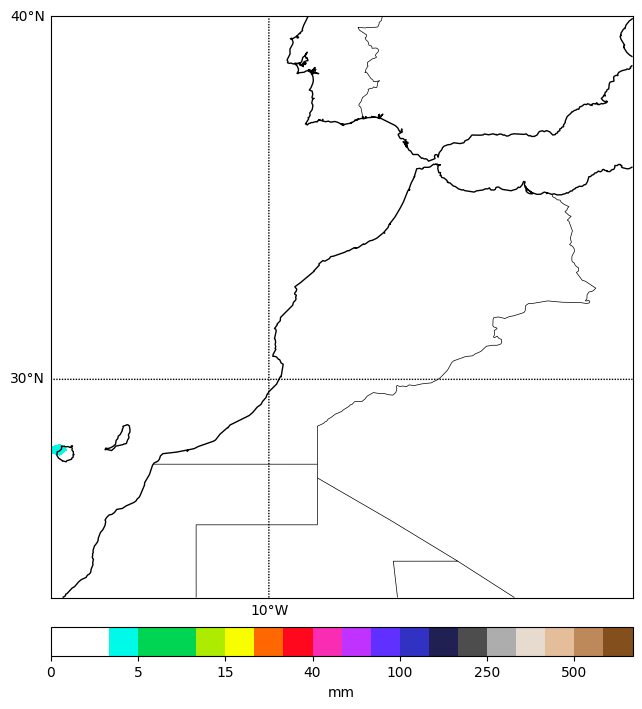

In [ ]:
plot_precip(fakeSamples[10])

## Generate Fake images with Distribution shifting

In [ ]:
optimizerG = optim.Adam(UnconditionalG.parameters(), lr=2e-5, betas=BETAS)
optimizerD = optim.Adam(UnconditionalD.parameters(), lr=1e-5, betas=BETAS)

c = 0.75
k = 10
DIRNAME = 'DistShift/'
os.makedirs(DIRNAME, exist_ok=True)

fake_name = 'data/fake.pt'
for i in range(1, k):
    print("Distribution Shift: Iteration ", i)
    dataloader = DataLoader(NWSDataset(fake=fake_name, c=c, i=i), batch_size=256, shuffle=True)
    tk = tqdm(range(0, 100))
    for epoch in tk:
        lossG, lossD = trainGAN(dataloader, UnconditionalG, UnconditionalD, optimizerG, optimizerD)
        tk.set_postfix(lossG=lossG, lossD=lossD)
    with torch.no_grad():
        UnconditionalG.eval()
        fsize = int((1 - (c ** (i + 1))) * DATASET_SIZE / c)
        fakeSamples = UnconditionalG(torch.randn(fsize, LATENT_DIM, 1, 1).cuda()).cpu()
        sorted_indices = extremeness_measure(fakeSamples).numpy().argsort()[::-1].copy()
        fake_name = DIRNAME + 'fake' + str(i + 1) + '.pt'
        torch.save(fakeSamples.data[sorted_indices], fake_name)
        UnconditionalG.train()

Distribution Shift: Iteration  1


100%|██████████| 100/100 [00:03<00:00, 29.03it/s, lossD=3.42, lossG=1.63]


Distribution Shift: Iteration  2


100%|██████████| 100/100 [00:02<00:00, 34.45it/s, lossD=0.844, lossG=1.57]


Distribution Shift: Iteration  3


100%|██████████| 100/100 [00:02<00:00, 34.88it/s, lossD=2.66, lossG=1.26]


Distribution Shift: Iteration  4


100%|██████████| 100/100 [00:02<00:00, 34.95it/s, lossD=1.33, lossG=0.531]


Distribution Shift: Iteration  5


100%|██████████| 100/100 [00:03<00:00, 31.41it/s, lossD=1.72, lossG=0.467]


Distribution Shift: Iteration  6


100%|██████████| 100/100 [00:02<00:00, 34.79it/s, lossD=1.67, lossG=0.447]


Distribution Shift: Iteration  7


100%|██████████| 100/100 [00:02<00:00, 34.33it/s, lossD=1.74, lossG=0.39]


Distribution Shift: Iteration  8


100%|██████████| 100/100 [00:02<00:00, 34.11it/s, lossD=1.59, lossG=0.431]


Distribution Shift: Iteration  9


100%|██████████| 100/100 [00:03<00:00, 29.45it/s, lossD=1.45, lossG=0.695]


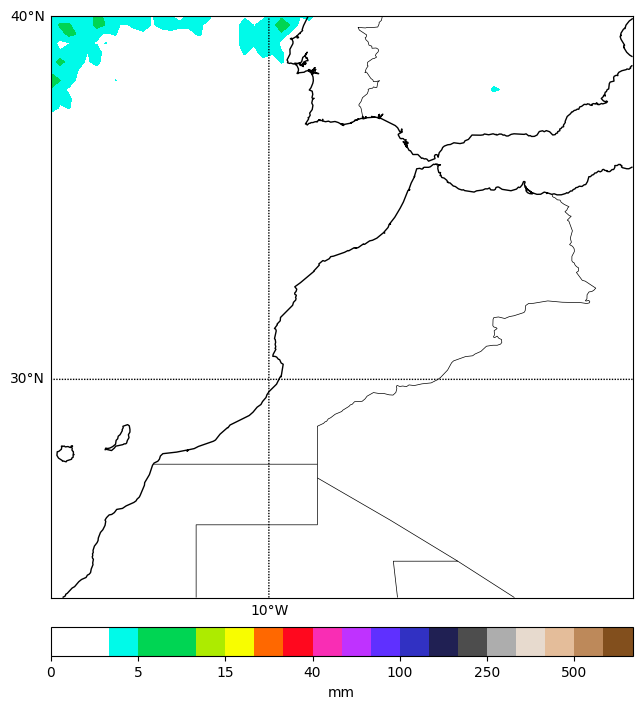

In [ ]:
plot_precip(torch.load(DIRNAME+'fake'+str(k)+'.pt')[12])

## Fitting a Generalized Pareto distribution

In [ ]:
dataset = NWSDataset(fake='DistShift/fake'+str(k)+'.pt', c=c, i=k, conditional=True)

In [ ]:
measures = extremeness_measure(dataset.data)
threshold = measures.min() # Already tail of the data
tail = measures[np.where(measures > threshold)[0]]

In [ ]:
genpareto_params = genpareto.fit(tail-threshold)

In [ ]:
# print the parameters you will need them for evaluation
print(genpareto_params)
print(threshold)

(0.45467089272564376, 4.243841361308569e-05, 0.0003078780456579492)
tensor(-0.9906)


## Training the model

In [ ]:
 class GeneratorConditional(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GeneratorConditional, self).__init__()
        self.block1 = convTINReLU(in_channels + 1, 512, 4, 1, 0)
        self.block2 = convTINReLU(512, 256)
        self.block3 = convTINReLU(256, 128)
        self.block4 = convTINReLU(128, 64)
        self.block5 = nn.ConvTranspose2d(64, out_channels, 4, 2, 1)

    def forward(self, latent, continuous_code):
        inp = torch.cat((latent, continuous_code), 1)
        out = self.block1(inp)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        return torch.tanh(self.block5(out))

class DiscriminatorConditional(nn.Module):
    def __init__(self, in_channels):
        super(DiscriminatorConditional, self).__init__()
        self.block1 = convINReLU(in_channels, 64)
        self.block2 = convINReLU(64, 128)
        self.block3 = convINReLU(128, 256)
        self.block4 = convINReLU(256, 512)
        self.block5 = nn.Conv2d(512, 64, 4, 1, 0)
        self.source = nn.Linear(64 + 1, 1)

    def forward(self, inp, extreme):
        sums = extremeness_measure(inp)
        diff = torch.abs(extreme.view(-1, 1) - sums.view(-1, 1)) / torch.abs(extreme.view(-1, 1))
        out = self.block1(inp)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        size = out.shape[0]
        out = out.view(size, -1)
        source = torch.sigmoid(self.source(torch.cat([out, diff], 1)))
        return source


criterionSource = nn.BCELoss()
G = GeneratorConditional(in_channels=LATENT_DIM, out_channels=1).cuda()
D = DiscriminatorConditional(in_channels=1).cuda()
G.apply(weights_init_normal)
D.apply(weights_init_normal)

rv = genpareto(*genpareto_params)

c = 0.75
k = 10

def sample_genpareto(size):
    probs = torch.rand(size)
    return FloatTensor(rv.ppf(probs)) + threshold


optimizerG = optim.Adam(G.parameters(), lr=2e-4, betas=BETAS)
optimizerD = optim.Adam(D.parameters(), lr=1e-4, betas=BETAS)
static_code = sample_genpareto((81, 1, 1, 1)).cuda()
static_z = FloatTensor(torch.randn((81, LATENT_DIM, 1, 1))).cuda()

def sample_image(batches_done):
    static_sample = G(static_z, static_code).cpu()
    static_sample = (static_sample + 1) / 2.0
    save_image(static_sample, DIRNAME + "%d.png" % batches_done, nrow=9)

DIRNAME = 'ExGAN/'
os.makedirs(DIRNAME, exist_ok=True)
fakename = 'DistShift/fake'+str(k)+'.pt'
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)
tk = tqdm(range(0, 1000)) # Actual Number of Epochs is 1000
for epoch in tk:
    noise = 1e-5 * max(1 - (epoch / 1000.0), 0)
    for images, labels in dataloader:
        batch_size = images.shape[0]
        trueTensor, falseTensor = getTrueFalseTensors(batch_size)
        images, labels = images.cuda(), labels.view(-1, 1).cuda()
        realSource = D(images, labels)
        realLoss = criterionSource(realSource, trueTensor.expand_as(realSource))
        latent = torch.randn(batch_size, LATENT_DIM, 1, 1).cuda()
        code = sample_genpareto((batch_size, 1, 1, 1)).cuda()
        fakeGen = G(latent, code)
        fakeGenSource = D(fakeGen.detach(), code)
        fakeGenLoss = criterionSource(fakeGenSource, falseTensor.expand_as(fakeGenSource))
        lossD = realLoss + fakeGenLoss
        optimizerD.zero_grad()
        lossD.backward()
        torch.nn.utils.clip_grad_norm_(D.parameters(), 20)
        optimizerD.step()
        fakeGenSource = D(fakeGen, code)
        fakeLabels = extremeness_measure(fakeGen)
        L_ext = torch.mean(torch.abs((fakeLabels - code.view(batch_size)) / code.view(batch_size)))
        lossG = criterionSource(fakeGenSource, trueTensor.expand_as(fakeGenSource)) + L_ext
        optimizerG.zero_grad()
        lossG.backward()
        torch.nn.utils.clip_grad_norm_(G.parameters(), 20)
        optimizerG.step()
    tk.set_postfix(lossG=lossG.item(), lossD=lossD.item())

100%|██████████| 1000/1000 [00:59<00:00, 16.94it/s, lossD=0.997, lossG=2.74]


In [ ]:
# save the model
import torch
torch.save(G, "G.pt")
torch.save(G.state_dict(), 'G_dict.pt')

In [ ]:
# in case you want to download the model to your local machine
from google.colab import files
files.download('G.pt')
files.download('G_dict.pt')

## Generate new images

In [ ]:
G.eval()
tau = 1/(365*100) # play with the threshold
tau_prime = tau/c**k
val = rv.ppf((1-tau_prime)) + threshold
code = torch.ones(1000, 1, 1, 1).cuda()*val # this generates 1000 new images
latent = torch.randn((1000, LATENT_DIM, 1, 1)).cuda()
with torch.no_grad():
  images = G(latent, code).cpu()

In [ ]:
((images[:,0,45,40]+1)*100).max()

tensor(3.2626)

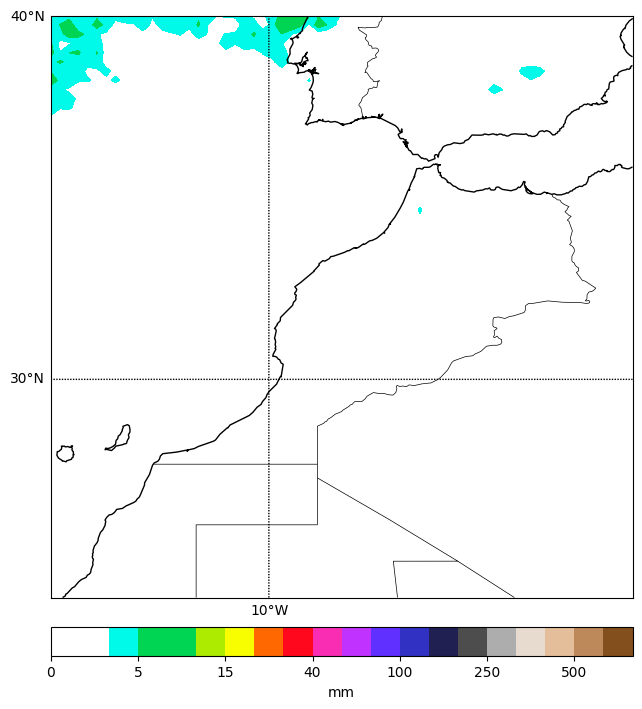

In [ ]:
plot_precip(images[9]) # Feel free to change tau, and look at more samples

## Evaluation of ExGAN

#### Generate images with different thresholds of extremeness



In [ ]:
def convTBNReLU(in_channels, out_channels, kernel_size=4, stride=2, padding=1):
    return nn.Sequential(
        nn.ConvTranspose2d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
        ),
        nn.InstanceNorm2d(out_channels),
        nn.LeakyReLU(0.2, True),
    )


class Generator(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Generator, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.block1 = convTBNReLU(in_channels + 1, 512, 4, 1, 0)
        self.block2 = convTBNReLU(512, 256)
        self.block3 = convTBNReLU(256, 128)
        self.block4 = convTBNReLU(128, 64)
        self.block5 = nn.ConvTranspose2d(64, out_channels, 4, 2, 1)

    def forward(self, latent, continuous_code):
        inp = torch.cat((latent, continuous_code), 1)
        out = self.block1(inp)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        return torch.tanh(self.block5(out))

latentdim = 20
G = Generator(in_channels=latentdim, out_channels=1).cuda()
genpareto_params = (1.33, 0, 0.0075761900937239765)
threshold = -0.946046018600464
rv = genpareto(*genpareto_params)

G.load_state_dict(torch.load('G_dict.pt'))
G.eval()

c = 0.75
k = 10
for tau in [0.05, 0.02, 0.01,1/(365*10), 1/(365*100)]:
    tau_prime = tau / (c**k)
    val = rv.ppf(1-tau_prime) + threshold
    code = Variable(torch.ones(500, 1, 1, 1)*val).cuda(0)
    latent = Variable(FloatTensor(torch.randn((500, latentdim, 1, 1)))).cuda(0)
    images = G(latent, code)
    torch.save(0.5*(images+1), 'ExGAN'+str(tau)+'.pt')

0.003353118896484375
0.0030176639556884766
0.006348609924316406
0.002890348434448242
0.002061605453491211


#### Compute the reconstruction loss function(ability to reconstruct unseen extreme samples)



In [ ]:
def convTBNReLU(in_channels, out_channels, kernel_size=4, stride=2, padding=1):
    return nn.Sequential(
        nn.ConvTranspose2d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
        ),
        nn.InstanceNorm2d(out_channels),
        nn.LeakyReLU(0.2, True),
    )


class Generator(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Generator, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.block1 = convTBNReLU(in_channels + 1, 512, 4, 1, 0)
        self.block2 = convTBNReLU(512, 256)
        self.block3 = convTBNReLU(256, 128)
        self.block4 = convTBNReLU(128, 64)
        self.block5 = nn.ConvTranspose2d(64, out_channels, 4, 2, 1)

    def forward(self, latent, continuous_code):
        inp = torch.cat((latent, continuous_code), 1)
        out = self.block1(inp)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        return torch.tanh(self.block5(out))

latentdim = 20
G = Generator(in_channels=latentdim, out_channels=1).cuda()
genpareto_params = (1.33, 0, 0.0075761900937239765)
threshold = -0.946046018600464
rv = genpareto(*genpareto_params)

G.load_state_dict(torch.load('G_dict.pt'))
G.eval()

num = 1503
G.requires_grad = False
real = torch.load('data/real.pt').cuda()
z = torch.zeros((num, latentdim, 1, 1)).cuda()
code = (real.sum((1, 2, 3))/4096).view((num, 1, 1, 1))
z.requires_grad = True
optimizer = torch.optim.Adam([z], lr=1e-2)
criterion = nn.MSELoss()
for i in range(2000):
    pred = G(z, code)
    loss = criterion(pred, real)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(loss)

tensor(0.0029, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0028, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0027, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0027, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0026, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0026, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0025, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0024, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0024, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0024, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0023, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0023, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0022, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0022, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0022, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0021, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0021, device='cuda:0', grad_fn=

KeyboardInterrupt: ignored

### Define and compute the FID metric (ability to learn the distribution)

> train an autoencoder on test data



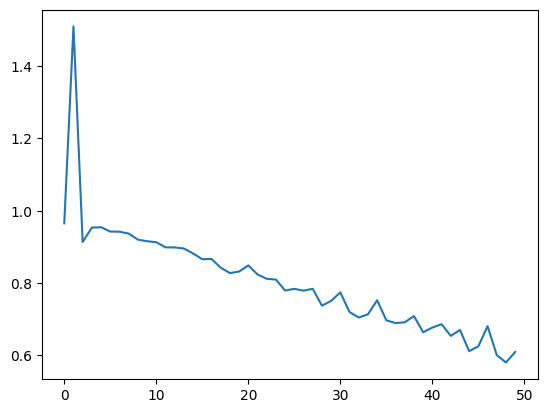

In [ ]:
data = torch.load('test/test.pt')
numSamples = 57
EPOCHS = 50
loss_func = nn.L1Loss()

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(4096,128), nn.ReLU(True), nn.Dropout())
        self.decoder = nn.Sequential(nn.Linear(128,4096))

    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

ae = AutoEncoder().cuda()
optimizer = torch.optim.Adam(ae.parameters(), lr=1e-3)
data = data.reshape(data.shape[0], -1)[:numSamples]
losses = []

for epoch in range(EPOCHS):
    x = torch.autograd.Variable(data[torch.randperm(numSamples)]).cuda()
    optimizer.zero_grad()
    pred = ae(x)
    loss = loss_func(pred, x)
    losses.append(loss.cpu().data.item())
    loss.backward()
    optimizer.step()
plt.plot(losses)


> compute the FID metric usinf the trained autoencoder



In [ ]:
ae.eval()
data = torch.load('test/test.pt')[0:57]
def FID(mu1, mu2, sigma1, sigma2):
    eps=1e-30
    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, "Training and test mean vectors have different lengths"
    assert sigma1.shape == sigma2.shape, "Training and test covariances have different dimensions"

    diff = mu1 - mu2
    # product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = "fid calculation produces singular product; adding %s to diagonal of cov estimates" % eps
        warnings.warn(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError("Imaginary component {}".format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)
    return diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean

def calcFID(data):
    data = data.reshape(data.shape[0], -1)
    features = ae.encoder(data.cuda()).detach().cpu().numpy()
    mean, covar = np.mean(features, 0), np.cov(features, rowvar=False)
    return FID(mean, base_mean, covar, base_covar)

gen_data = torch.load("ExGAN0.05.pt")[0:57]
gen_data = gen_data.reshape(gen_data.shape[0], -1)
base_features = ae.encoder(gen_data.cuda()).detach().cpu().numpy()
base_mean, base_covar = np.mean(base_features, 0), np.cov(base_features, rowvar=False)
calcFID(data)

86.52360629621599

### save the results into netcdf

In [ ]:
# Save the Netcdf
# ---------------------
nyears = 1000;
unout = 'days since 2000-01-01 00:00:00'
# -----------------------
ny, nx = (64,64)
lon = np.linspace(-16,0,nx);
lat = np.linspace(24,40,ny);
maps = np.zeros(shape=(1000, 64,64))
for i in range(0,1000) :
  maps[i] = resize(images[i, 0, ...], (64,64))
maps = (maps+1)*50
dataout = maps # create some random data
datesout = [datetime.datetime(2000+iyear,1,1) for iyear in range(nyears)]; # create datevalues
# =========================
ncout = Dataset('Generated_precipitation_100year.nc','w','NETCDF3'); # using netCDF3 for output format
ncout.createDimension('lon',nx);
ncout.createDimension('lat',ny);
ncout.createDimension('time',nyears);
lonvar = ncout.createVariable('lon','float32',('lon'));lonvar[:] = lon;
latvar = ncout.createVariable('lat','float32',('lat'));latvar[:] = lat;
timevar = ncout.createVariable('time','float64',('time'));timevar.setncattr('units',unout);timevar[:]=date2num(datesout,unout);
myvar = ncout.createVariable('tp','float32',('time','lat','lon'));myvar.setncattr('units','mm');myvar[:] = dataout;
ncout.close();